### **Recommender**

#### Download data

In [ ]:
import re
import requests
from collections import namedtuple

# 1. Download data
#   1.1 Movies
#   1.2 Stars
#   1.3 Producers

# https://triplydb.com/Triply/linkedmdb/insights/classFrequency?graph=https%3A%2F%2Ftriplydb.com%2FTriply%2Flinkedmdb%2Fgraphs%2Fdata

In [86]:
BASE_ENDPOINT = (
    "https://api.triplydb.com/datasets/Triply/linkedmdb/services/linkedmdb/sparql"
)

HEADERS = {
    "Content-Type": "application/sparql-query",
    "Accept": "application/sparql-results+json",
}

QUERY = """
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX lmdb: <https://triplydb.com/Triply/linkedmdb/vocab/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT DISTINCT ?film_id ?title ?release_date ?runtime ?sequel ?prequel 
	   (GROUP_CONCAT(DISTINCT ?genre_name; SEPARATOR=",") AS ?genres)
       (GROUP_CONCAT(DISTINCT ?subject_name; SEPARATOR=",") AS ?subjects)
       (GROUP_CONCAT(DISTINCT ?actor_name; SEPARATOR=",") AS ?actors) 
       (GROUP_CONCAT(DISTINCT ?director_name; SEPARATOR=",") AS ?directors)
       
    WHERE {{
  		?sub a lmdb:Film.
  		?sub lmdb:filmid ?film_id.
  		?sub rdfs:label ?title.
  		OPTIONAL {{?sub lmdb:initial_release_date ?release_date.}}
  		OPTIONAL {{?sub lmdb:runtime ?runtime.}}
  		OPTIONAL {{?sub lmdb:sequel ?sequel.}}
  		OPTIONAL {{?sub lmdb:prequel ?prequel.}}
    	OPTIONAL {{?sub lmdb:actor ?actor. ?actor rdfs:label ?actor_name}}
  		OPTIONAL {{?sub lmdb:film_subject ?subject. ?subject rdfs:label ?subject_name}}
  		OPTIONAL {{?sub lmdb:director ?director. ?director rdfs:label ?director_name}}
  		OPTIONAL {{?sub lmdb:genre ?genre. ?genre rdfs:label ?genre_name}}
    }}
GROUP BY ?film_id ?title ?release_date ?runtime ?sequel ?prequel
LIMIT 1000
OFFSET {offset}
"""

In [87]:
def query_movies(offset):
    query = QUERY.format(offset=offset)
    response = requests.post(BASE_ENDPOINT, headers=HEADERS, data=query)

    # Check if the request was successful
    if response.status_code == 200:
        return response.json()

    else:
        print(f"Request failed with status code {response.status_code}. Reason: {response.text}")
    

def extract_year(date_str):
    match = re.match(r'(\d{4})', date_str)
    return match.group(1) if match else ""


def extract_value(attribute):
    if isinstance(attribute, dict) and 'value' in attribute:
        return attribute['value']
    return attribute

In [94]:
# Define the Movie namedtuple
Movie = namedtuple("Movie", "film_id title release_date genres subjects runtime actors sequel prequel directors")

# Initialize lists to store data
movies = []
stars = []
producers = []
genres = []
subjects = []

# Define retrieval settings
offset = 0 # 102000 is roughly the max num
step_size = 1000 
more_movies_available = True

default_values = {
    "film_id": 0,
    "title": "",
    "release_date": 0,
    "genres": None,
    "runtime": 0,
    "actors": None,
    "sequel": "",
    "prequel": "",
    "directors": None,
    "subjects": None
}

# Main data retrieval loop
while more_movies_available:
    try:
        response = query_movies(offset)
        
        more_movies_available = len(response["results"]["bindings"]) > 0
        
        print(response)
        
        # more_movies_available = False
        
        for movie in response["results"]["bindings"]:

            if movie.get("release_date"):
                year = extract_year(movie["release_date"]["value"])
                movie["release_date"] = year
            
            merged_data = {k: extract_value(v) for k, v in {**default_values, **movie}.items()}        
            movies.append(Movie(**merged_data))
        
    except requests.exceptions.RequestException:
        print("COULD NOT RETRIEVE MOVIE DATA.")
        break
    
    # Increment the offset for the next iteration
    offset += step_size

{'head': {'link': [], 'vars': ['film_id', 'title', 'release_date', 'runtime', 'sequel', 'prequel', 'genres', 'subjects', 'actors', 'directors']}, 'results': {'bindings': [{'film_id': {'type': 'literal', 'value': '65517', 'datatype': 'http://www.w3.org/2001/XMLSchema#int'}, 'title': {'type': 'literal', 'value': 'Una Historia de tango'}, 'release_date': {'type': 'literal', 'value': ''}, 'genres': {'type': 'literal', 'value': ''}, 'subjects': {'type': 'literal', 'value': ''}, 'actors': {'type': 'literal', 'value': ''}, 'directors': {'type': 'literal', 'value': ''}}, {'film_id': {'type': 'literal', 'value': '79556', 'datatype': 'http://www.w3.org/2001/XMLSchema#int'}, 'title': {'type': 'literal', 'value': 'Wild Bananas on Butt Row'}, 'release_date': {'type': 'literal', 'value': '1997'}, 'genres': {'type': 'literal', 'value': ''}, 'subjects': {'type': 'literal', 'value': ''}, 'actors': {'type': 'literal', 'value': 'Shay Sweet (Actor)'}, 'directors': {'type': 'literal', 'value': ''}}, {'film

#### Construct Graph

In [99]:
# Make all unique attributes into nodes from KG.
# Idea: Relate movies by their matching unique attributes (that are now nodes), and can be traversed over them as a bridge between the movies.

import networkx as nx

G = nx.DiGraph()

for movie in movies:
    # Create a movie node
    G.add_node(movie.film_id, type='movie', label=movie.title)
    
    # Splitting and adding genre nodes
    if movie.genres:
        for genre in movie.genres.split(','):
            G.add_node(genre, type='genre', label=genre)
            G.add_edge(movie.film_id, genre, relationship='HAS_GENRE')

    # Splitting and adding subject nodes
    if movie.subjects:
        for subject in movie.subjects.split(','):
            G.add_node(subject, type='subject', label=subject)
            G.add_edge(movie.film_id, subject, relationship='HAS_SUBJECT')

    # Splitting and adding actor nodes
    if movie.actors:
        for actor in movie.actors.split(','):
            G.add_node(actor, type='actor', label=actor)
            G.add_edge(movie.film_id, actor, relationship='HAS_ACTOR')

    # Splitting and adding director nodes
    if movie.directors:
        for director in movie.directors.split(','):
            G.add_node(director, type='director', label=director)
            G.add_edge(movie.film_id, director, relationship='HAS_DIRECTOR')

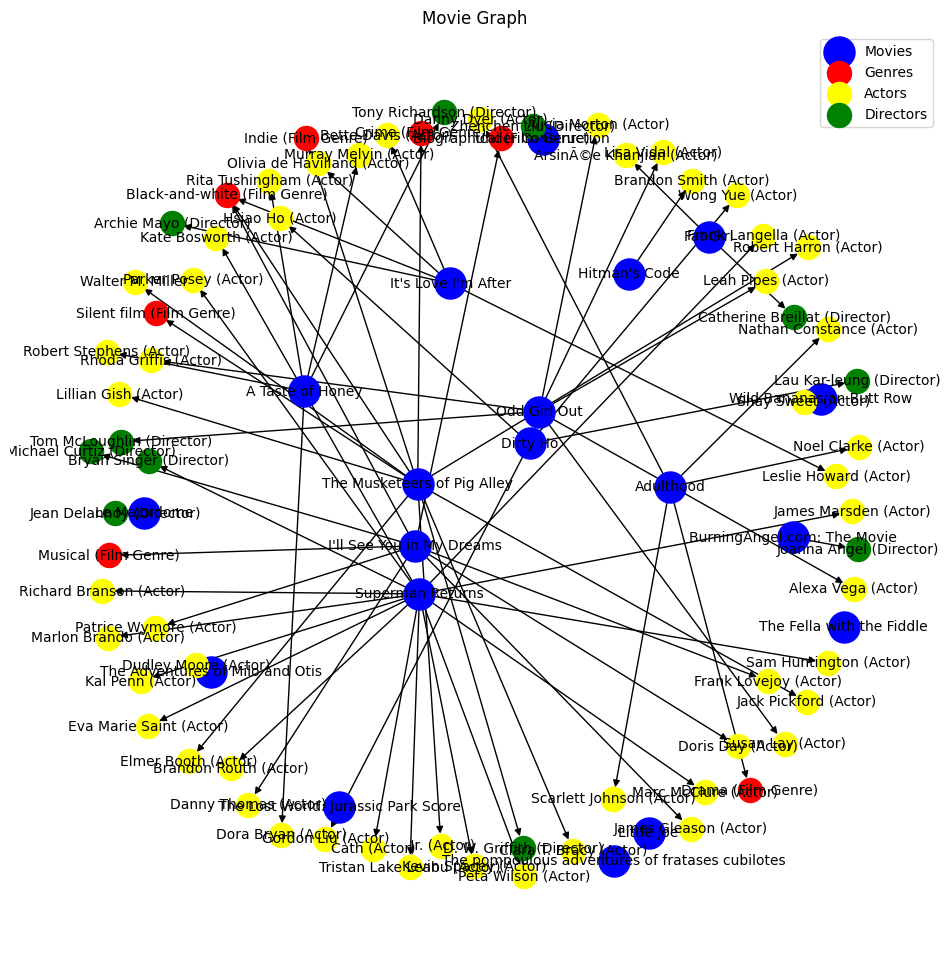

In [100]:
import matplotlib.pyplot as plt

# Using the previous graph G
pos = nx.spring_layout(G)  # Positioning of nodes
plt.figure(figsize=(12, 12))  # Set figure size

# Draw nodes based on their type for differentiated visualization
nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['type'] == 'movie'], node_color='blue', node_size=500, label='Movies')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['type'] == 'genre'], node_color='red', node_size=300, label='Genres')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['type'] == 'actor'], node_color='yellow', node_size=300, label='Actors')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['type'] == 'director'], node_color='green', node_size=300, label='Directors')
nx.draw_networkx_nodes(G, pos, nodelist=[node for node, attr in G.nodes(data=True) if attr['type'] == 'subject'], node_color='purple', node_size=300, label='Subjects')

# Draw edges
nx.draw_networkx_edges(G, pos)

# Draw labels
labels = {node: attr['label'] for node, attr in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

# Add legend
plt.legend()

plt.title("Movie Graph")
plt.axis('off')  # Hide axis
plt.show()

#### Train Model

In [104]:
from node2vec import Node2Vec

# Assuming your graph is stored in variable G
node2vec = Node2Vec(G, dimensions=64, walk_length=20, num_walks=200, workers=4)  # Use temp_folder for big graphs

# Learn embeddings 
model = node2vec.fit(window=10, min_count=1, batch_words=4)  # Any keywords acceptable by gensim.Word2Vec can be passed

# Get vector for a specific node
vector = model.wv['Adulthood']  # Use the node's name as the key

# Save embeddings for later use
model.save("embeddings.model")

# Load embeddings if needed
# model = Word2Vec.load("embeddings.model")

Computing transition probabilities: 100%|██████████| 88/88 [00:00<00:00, 69997.87it/s]


KeyError: "Key 'Adulthood' not present"

In [101]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the embeddings
labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model.wv[word])
    labels.append(word)

# Reduce dimensionality with t-SNE
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))
for i in range(len(x)):
    plt.scatter(x[i], y[i])
    plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.show()

NameError: name 'model' is not defined

#### Run Model